In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [22]:
%matplotlib notebook
%matplotlib inline

In [4]:
pd.options.display.max_rows = 6
pd.options.display.max_columns = 12

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

In [5]:
def ym_to_t(ym):
    y = int(ym[:4])
    m = (int(ym[5:]) - 0.5) / 12
    return y + m



In [6]:
print(ym_to_t('2016/06'))

2016.4583333333333


In [7]:
# 時刻 t を　yyyy/mm 形式の文字列に変換する
# 時刻 t が yyyy年 mm月の1日〜月末にあれば、　yyyy/mm を返す

def t_to_ym(t):
    y = int(t)
    m = int((t - y) * 12) + 1
    m = max(min(m, 12), 1)
    #月部分を２桁表示になるようにパディングする
    return str(y) + '/' + str(m).zfill(2)

In [8]:
print(t_to_ym(2019.49))

2019/06


In [9]:
df_birth = pd.read_csv('ipss_birth.csv')
df_birth

,year,sex,ratio,cum_ratio
0,1947,F,0.012150,0.012150
1,1948,F,0.012162,0.024311
2,1949,F,0.012288,0.036600
...,...,...,...,...
137,2014,M,0.004812,0.990505
138,2015,M,0.004811,0.995316
139,2016,M,0.004684,1.000000


In [13]:
# 分析開始時点
start_study_t = 2010

#分析終了時点
end_study_t = 2019.999


#指数分布のパラメタ
#観測開始期間、観察終了期間を決定する
mu = 10

#N 人の加入者を生成する
N = 5000

#全体の内、被扶養者の占める割合
family_ratio = 0.3

In [49]:
# 変数初期化
i = 0

#random seed
rs= 0
np.random.seed(rs)


df_info = pd.DataFrame()


while len(df_info) < N:
    # 一様乱数
    r = np.random.rand()
    #乱数シード更新
    rs = rs + 1
    np.random.seed(rs)
    # ss : pd.Series
    ss = df_birth[df_birth['cum_ratio'] >= r].iloc[0]
    sex = ss.sex
    by = ss.year
    # 誕生月を一様に分布させる
    # Birth Time -> Birth Year Time
    bt = by + np.random.rand()
    rs = rs + 1
    np.random.seed(rs)
    bym = t_to_ym(bt)
    
    #擬似データにおいては観察開始期間、観察終了期間は指数分布で決定する
    start_t = start_study_t - mu  + np.random.exponential(mu)
    rs = rs + 1
    np.random.seed(rs)
    end_t = start_t + np.random.exponential(mu)
    rs = rs + 1
    np.random.seed(rs)
    # | は論理和（or）
    if (end_t < start_study_t) | (end_study_t < start_t):
        # 分析期間に在籍しない場合 -> 何もしない
        pass
    else:
        # iid 個人ID
        cols = ['iid', 'sex', 'family', 'birth_ym',
               'start_obs_ym', 'end_obs_ym']
        df_expouse = pd.DataFrame(np.zeros(len(cols)).reshape(1, len(cols)), 
                                  columns = cols)
        #本人:1, 家族：２
        family = 2 - (np.random.rand() > family_ratio)
        rs = rs + 1
        np.random.seed(rs)
        df_expouse[cols] = ['i' + str(i).zfill(6), sex, family, bym,
                           t_to_ym(start_t), t_to_ym(end_t)]
        
        #df_info　の下に
        # 新しく作成した１列データフレーム　df_exposureを追加する
        df_info = pd.concat([df_info, df_expouse], axis = 0)
    i = i+1
    
# index の振り直し
df_info = df_info.reset_index()
#reset_index()により作成されてしまった index という列を消す
del df_info['index']

In [50]:
df_info

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym
0,i000000,M,1.0,1952/06,2005/09,2013/09
1,i000001,F,2.0,1972/11,2000/10,2021/06
2,i000002,M,1.0,1978/03,2001/09,2016/09
...,...,...,...,...,...,...
4997,i008260,M,1.0,1987/02,2019/06,2026/01
4998,i008263,M,1.0,1980/08,2007/09,2016/11
4999,i008264,M,2.0,1952/06,2005/02,2010/10


In [51]:
df_birth = pd.read_csv('ipss_birth.csv')

Text(0.5, 1.0, 'Birth Ratio (M)')

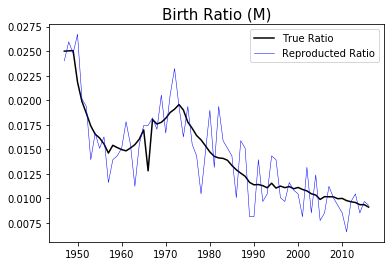

In [52]:
# 真の比率 vs 擬似生成された誕生年の比率（男性のみ）を図で表現

# 真の出生比率
df_birth_M = df_birth.loc[df_birth.sex == 'M', ['year', 'ratio']]
df_birth_M['ratio'] = df_birth_M.ratio / df_birth_M.ratio.sum()

#擬似生成された加入者の出生比率
df_info_M = df_info.loc[df_info.sex == 'M', ['birth_ym', 'family']]
df_info_M['birth_ym'] = df_info_M.birth_ym.apply(ym_to_t) // 1
df_info_M = df_info_M.groupby(['birth_ym']).count()
df_info_M = df_info_M / df_info_M.sum()
df_info_M

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df_birth_M.year, df_birth_M.ratio, c = 'k', label = 'True Ratio')
ax.plot(df_info_M.index, df_info_M.family, c = 'b', label = 'Reproducted Ratio', lw = 0.5)
ax.legend(loc='best')
ax.set_title('Birth Ratio (M)', fontsize = 15)

Text(0.5, 1.0, 'Observation Period vs Study Period')

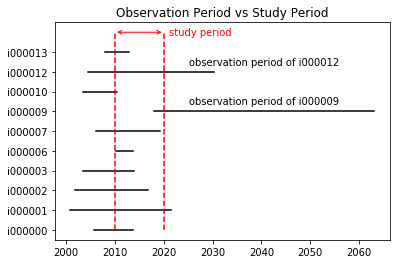

In [53]:
# 観察期間と分析期間の概念図

df = df_info.iloc[:10].copy()
df['start_obs_t'] = df.start_obs_ym.apply(ym_to_t)
df['end_obs_t'] = df.end_obs_ym.apply(ym_to_t)

fig = plt.figure()
ax = fig.add_subplot(111)

for i in df.index:
    X = df.loc[i, ['start_obs_t', 'end_obs_t']]
    Y = [i, i]
    ax.plot(X, Y, c = 'k')

ax.plot([start_study_t, start_study_t], [0, 10], c = 'r', ls = '--')
ax.plot([end_study_t, end_study_t], [0, 10], c = 'r',ls = '--')
ax.annotate('', xy = (end_study_t, 10), xytext = (start_study_t, 10),
           arrowprops = dict(arrowstyle = '<->', color = 'r'))

#分析期間
x = end_study_t + 1
y = 10
t = 'study period'
ax.text(x, y, t, color = 'r', va = 'center', ha = 'left')
# iid = i000009の観察期間
x = (df.loc[6, 'start_obs_t'] + df.loc[6, 'end_obs_t']) / 2
y = 6.5
t = 'observation period of i000009'
ax.text(x, y, t, color = 'k', va = 'center', ha = 'center')
#iid = i000012
y = 8.5
t = 'observation period of i000012'
ax.text(x, y, t, color = 'k', va = 'center', ha = 'center')

ax.set_yticks(df.index)
ax.set_yticklabels(df.iid)
ax.set_title('Observation Period vs Study Period')

In [54]:
df_info

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym
0,i000000,M,1.0,1952/06,2005/09,2013/09
1,i000001,F,2.0,1972/11,2000/10,2021/06
2,i000002,M,1.0,1978/03,2001/09,2016/09
...,...,...,...,...,...,...
4997,i008260,M,1.0,1987/02,2019/06,2026/01
4998,i008263,M,1.0,1980/08,2007/09,2016/11
4999,i008264,M,2.0,1952/06,2005/02,2010/10


In [46]:
# 観察開始年月の分析開始時点での制限
df_info['start_obs_t'] = df_info['start_obs_ym'].apply(ym_to_t)
# 時刻が文字列のままでも大小比較は可能、
# 数値に変換しておくと次の年齢の計算で便利なので数値にすることとする

more_start_study = (df_info['start_obs_t'] > start_study_t)
df_info['start_obs_t'] = more_start_study * df_info['start_obs_t'] \
    + ~more_start_study * start_study_t

# -----------------
# ~ は論理否定演算子、False→True, True→False, 0→1、1→0

df_info['start_obs_ym'] = df_info['start_obs_t'].apply(t_to_ym)


# 観察終了年月
df_info['end_obs_t'] = df_info['end_obs_ym'].apply(ym_to_t)
less_end_study = (df_info['end_obs_t'] < end_study_t)
df_info['end_obs_t'] = less_end_study * df_info['end_obs_t'] \
    + less_end_study * end_study_t

df_info['end_obs_ym'] = df_info['end_obs_t'].apply(t_to_ym)
df_info['birth_t'] = df_info['birth_ym'].apply(ym_to_t)

In [48]:
df_info

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,start_obs_t,end_obs_t,birth_t
0,i000000,M,1.0,1952/06,0/01,4033/09,0.000000,4033.707333,1952.458333
1,i000001,F,2.0,1972/11,0/01,0/01,0.000000,0.000000,1972.875000
2,i000002,M,1.0,1978/03,0/01,4036/09,0.000000,4036.707333,1978.208333
...,...,...,...,...,...,...,...,...,...
4997,i008260,M,1.0,1987/02,4029/06,0/01,4029.458333,0.000000,1987.125000
4998,i008263,M,1.0,1980/08,0/01,4036/11,0.000000,4036.874000,1980.625000
4999,i008264,M,2.0,1952/06,0/01,4030/10,0.000000,4030.790667,1952.458333


In [55]:
# 観察開始年月の分析開始時点での制限
df_info['start_obs_t'] = df_info['start_obs_ym'].apply(ym_to_t)
# ---------------
# 時刻が文字列のままでも大小比較は可能ですが、
# 数値に変換しておくと次の年齢の計算で便利なので数値にすることとします。
more_start_study = (df_info['start_obs_t'] > start_study_t)
df_info['start_obs_t'] = more_start_study * df_info['start_obs_t'] \
 + ~more_start_study * start_study_t
# -----------------
# ~ は論理否定演算子、False→True, True→False, 0→1、1→0
df_info['start_obs_ym'] = df_info['start_obs_t'].apply(t_to_ym)
# 観察終了年月の分析終了時点での制限
df_info['end_obs_t'] = df_info['end_obs_ym'].apply(ym_to_t)
less_end_study = (df_info['end_obs_t'] < end_study_t)
df_info['end_obs_t'] = less_end_study * df_info['end_obs_t'] \
 + ~less_end_study * end_study_t
df_info['end_obs_ym'] = df_info['end_obs_t'].apply(t_to_ym)
df_info['birth_t'] = df_info['birth_ym'].apply(ym_to_t)

In [60]:
types = {
    'iid':'str',
    'sex':'str',
    'family':'int8',
    'birth_ym':'str',
    'start_obs_ym':'str',
    'end_obs_ym':'str',
    'start_obs_t':'float32',
    'end_obs_t':'float32',
    'birth_t':'float32'
}

df_info = df_info.astype(types)
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
iid             5000 non-null object
sex             5000 non-null object
family          5000 non-null int8
birth_ym        5000 non-null object
start_obs_ym    5000 non-null object
end_obs_ym      5000 non-null object
start_obs_t     5000 non-null float32
end_obs_t       5000 non-null float32
birth_t         5000 non-null float32
dtypes: float32(3), int8(1), object(5)
memory usage: 258.9+ KB


In [64]:
# np.array形式で一連の観察期間 'yyyy/mm'を作成

def creat_npa_obs_ym(start_study_t, end_study_t):
    t = start_study_t
    obs_ym = []
    while t < end_study_t:
        ym = t_to_ym(t)
        obs_ym.append(ym)
        t = ym_to_t(ym) + 1 / 12
    return np.array(obs_ym)

# 一連の観察期間を時刻 t(スカラー)に変換
def convert_ym_to_t_in_npa(npa_obs_ym):
    return np.array(pd.Series(npa_obs_ym).apply(ym_to_t))

npa_obs_ym = creat_npa_obs_ym(start_study_t, end_study_t)
npa_obs_t = convert_ym_to_t_in_npa(npa_obs_ym)
npa_birth_t = np.array(df_info['birth_t'])


df_alb_table = df_info.copy()
for i in np.arange(len(npa_obs_ym)):
    # "//" で商(整数)をとる。ちなみに剰余演算子は "%"
    # df_alb_table に新しい列を追加しながら、計算した ALB 列を代入している
    
    df_alb_table[npa_obs_ym[i]] = (npa_obs_t[i] - npa_birth_t) // 1
    df_alb_table[npa_obs_ym[i]] = df_alb_table[npa_obs_ym[i]].astype('int8')

In [67]:
df_alb_table.head()

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,67,67,67,67,67,67
1,i000001,F,2,1972/11,2010/01,2019/12,...,46,46,46,46,47,47
2,i000002,M,1,1978/03,2010/01,2016/09,...,41,41,41,41,41,41
3,i000003,M,2,1989/03,2010/01,2013/12,...,30,30,30,30,30,30
4,i000006,M,1,1973/11,2010/04,2013/09,...,45,45,45,45,46,46


In [68]:
df_mortality = pd.read_csv('ipss_mortality.csv')
df_mortality

,alb,F,M
0,0,0.000098,0.000097
1,1,0.000020,0.000022
2,2,0.000011,0.000013
...,...,...,...
97,97,0.023992,0.034089
98,98,0.027662,0.038338
99,99,0.031471,0.043682


In [75]:
df_mortality_table = df_alb_table.copy()

for i in np.arange(len(npa_obs_ym)):
    df_mortality_table[npa_obs_ym[i]] = \
    df_mortality_table[npa_obs_ym[i]].astype('float64')
    

def get_mortality(df_mortality, sex, alb):
    if alb < 0 or 100 <= alb:
        return 0
    else:
        return df_mortality.loc[alb, sex]
    
# df_mortality_table のym 列に関する月次死亡率を np.array形式で計算
def calc_monthly_mortality_col(df_mortality, df_alb_table, ym):
    #加入者の性別一覧
    sexes = df_alb_table['sex']
    albs = df_alb_table[ym]
    mortalities = [get_mortality(df_mortality, sex, alb) for (sex, alb)
                  in zip(sexes, albs)]
    mortalities = np.array(mortalities)
    mortalities[np.isnan(mortalities)] = 0
    return mortalities

# df_mortality_table に月次死亡率を埋める
for ym in npa_obs_ym:
    mortalities = calc_monthly_mortality_col(df_mortality, df_alb_table, ym)
    df_mortality_table[ym] = mortalities

In [77]:
df_mortality_table

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,...,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2013/09,...,0.001166,0.001166,0.001166,0.001166,0.001166,0.001166
1,i000001,F,2,1972/11,2010/01,2019/12,...,0.000090,0.000090,0.000090,0.000090,0.000099,0.000099
2,i000002,M,1,1978/03,2010/01,2016/09,...,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4997,i008260,M,1,1987/02,2019/06,2019/12,...,0.000052,0.000052,0.000052,0.000052,0.000052,0.000052
4998,i008263,M,1,1980/08,2010/01,2016/11,...,0.000072,0.000077,0.000077,0.000077,0.000077,0.000077
4999,i008264,M,2,1952/06,2010/01,2010/10,...,0.001166,0.001166,0.001166,0.001166,0.001166,0.001166


In [79]:
# 通常エクスポージャは[人年]で計算されるが
# ここでは単位を[人月]とする

df_exposure_table = df_alb_table.copy()
for ym in npa_obs_ym:
    bs = (df_exposure_table['start_obs_t'] <= ym_to_t(ym))
    be = (ym_to_t(ym)) <= df_exposure_table['end_obs_t']
    bb = (df_exposure_table['birth_t'] <= ym_to_t(ym))
    ba = (df_alb_table[ym] < 65)
    df_exposure_table[ym] = (bs & be & bb & ba) * 1

In [80]:
df_exposure_table.shape

(5000, 129)

In [82]:
rs = 0
np.random.seed(rs)
np.random.random((2, 3))

array([[0.5488135 , 0.71518937, 0.60276338],
       [0.54488318, 0.4236548 , 0.64589411]])

In [83]:
df_death_table = df_alb_table.copy()


rs = 0
np.random.seed(rs)

df_random = np.random.random(df_death_table[npa_obs_ym].shape)
df_death_table[npa_obs_ym] = (df_random < df_mortality_table[npa_obs_ym]) \
    * df_exposure_table[npa_obs_ym] * 1

In [84]:
pd.options.display.max_rows = 20

print(df_death_table.iloc[17].iid, "\n")

df_death_table.loc[17, npa_obs_ym[12:]].head(10)

i000027 



2011/01    0
2011/02    0
2011/03    0
2011/04    1
2011/05    0
2011/06    0
2011/07    0
2011/08    0
2011/09    0
2011/10    0
Name: 17, dtype: object

In [87]:
# cumsum 1回適用
df_death_table[npa_obs_ym].cumsum(axis=1).loc[17, npa_obs_ym[12:]].head(10)

2011/01    0
2011/02    0
2011/03    0
2011/04    1
2011/05    1
2011/06    1
2011/07    1
2011/08    1
2011/09    1
2011/10    1
Name: 17, dtype: int64

In [91]:
df_death_table[npa_obs_ym] \
    = (df_death_table[npa_obs_ym].cumsum(axis=1).cumsum(axis=1)==1)*1

# 整数型に変更してメモリ効率をあげる
for i in np.arange(len(npa_obs_ym)):
    df_death_table[npa_obs_ym[i]] \
     = df_death_table[npa_obs_ym[i]].astype('int8')
    
#死亡後のエクスポージャを0に変更

before_death_filter = (df_death_table[npa_obs_ym].cumsum(axis=1).cumsum(axis=1) <= 1)*1
df_exposure_table[npa_obs_ym] = df_exposure_table[npa_obs_ym] * before_death_filter

In [93]:
#加入者情報データに死亡情報を追加
df_info['death'] = 0
df_info['death'] = df_info['death'].astype('int8')
df_info.loc[(df_death_table[npa_obs_ym].sum(axis=1) == 1), 'death'] = 1
# 死亡レコードがある者
# 当月のエクスポージャが 1、翌月のエクスポージャが0の時
# 当月が観察終了年月となる。
# エクスポージャを 1 か月ずらした差分が 1 となる年月が観察最終年月。
df_exp_dif = df_exposure_table[npa_obs_ym] \
    - df_exposure_table[npa_obs_ym].shift(-1, axis=1)
# ただし分析終了年月の翌月は存在しないため None となる。
# 分析終了年月 (2019/12) にエクスポージャが 1 の場合
# 分析終了年月年月が観察終了年月となる。
df_exp_dif[npa_obs_ym[-1]] = df_exposure_table[npa_obs_ym[-1]]

# 差分が -1 の箇所を 0 に変更。
df_exp_dif[df_exp_dif < 0] = 0

In [94]:
exposure_exists = (df_exposure_table[npa_obs_ym].sum(axis=1) > 0)
df_info = df_info[exposure_exists]
df_exposure_table = df_exposure_table[exposure_exists]

In [95]:
b = (df_info['start_obs_ym'] < df_info['birth_ym'])
df_info.loc[b, 'birth_ym'] = df_info.loc[b, 'start_obs_ym']
df_info.loc[b, 'birth_t'] = df_info.loc[b, 'start_obs_t']

In [96]:
# エクスポージャの最終年月を観察終了年月とする
for i in df_exposure_table.index:
    end_of_exp = (df_exp_dif.loc[i, npa_obs_ym] == 1)
    df_info.loc[i, 'end_obs_ym'] = npa_obs_ym[end_of_exp][0]
    
# 時刻 t に関する情報を削除し、カラムを並び替える
info_cols = ['iid', 'sex', 'family', 'birth_ym',
            'start_obs_ym', 'end_obs_ym', 'death']

df_info = df_info[info_cols]